In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from scipy.misc import toimage

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# import tensorflow as tf
import keras
from keras.datasets import cifar10
from keras.models import Sequential, load_model, Model
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras import regularizers, optimizers
# from keras.callbacks import TensorBoard, LearningRateScheduler

Using TensorFlow backend.


In [2]:
# Train-test splite 
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [3]:
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size = 0.2)

In [4]:
# Normalization 
mean = np.mean(x_train, axis = (0, 1, 2, 3))
std = np.std(x_train, axis = (0, 1, 2, 3))

x_train = (x_train - mean)/std
x_test = (x_test - mean)/std
x_valid = (x_valid - mean)/std

In [5]:
# Data augmentation
ImageGenerator = ImageDataGenerator(
    featurewise_center = False,
    featurewise_std_normalization = False,
    zca_whitening=True,
    rotation_range = 20,
    width_shift_range = 0.5,
    height_shift_range = 0.5,
    horizontal_flip = True,
    vertical_flip = True)
ImageGenerator.fit(x_train)

/home/ecbm4040/miniconda3/envs/dlenv/lib/python3.6/site-packages/keras_preprocessing/image.py:836: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


In [6]:
# Plot the image
aug_x = np.zeros((6,32,32,3))
aug_y = np.zeros((6,10))

for i in range(6):
    aug_x[i] = x_train[15]
    aug_y[i] = y_train[15]
    
ImageGenerator.fit(aug_x)

/home/ecbm4040/miniconda3/envs/dlenv/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
  after removing the cwd from sys.path.
/home/ecbm4040/miniconda3/envs/dlenv/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
  if __name__ == '__main__':


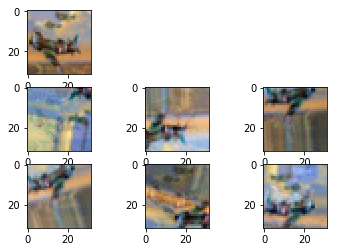

In [7]:
for x_img, y_img in ImageGenerator.flow(aug_x, aug_x, batch_size=9):
  
    plt.subplot(3,3,1)
    plt.imshow(toimage(aug_x[0]), cmap='gray')
    #plt.axis('off')
    
    for i in range(6):
        plt.subplot(3,3,i+4)
        plt.imshow(toimage(x_img[i]), cmap='gray')
        #plt.axis('off')
        
    plt.show()
    break

In [8]:
# Structure of the model

num_filters = 32
l2_norm = 0.0001
num_classes = len(np.unique(y_train))

model = Sequential()

model.add(Conv2D(num_filters, (3, 3), padding = 'same', kernel_regularizer = regularizers.l2(l2_norm), 
                 input_shape = (32, 32, 3))) # conv_1
model.add(Activation('elu')) # elu_1
model.add(BatchNormalization())
model.add(Conv2D(num_filters, (3, 3), padding = 'same', kernel_regularizer = regularizers.l2(l2_norm))) # conv_2
model.add(Activation('elu')) # elu_2
model.add(BatchNormalization())
model.add(Dropout(0.2)) # dropout_1
model.add(AveragePooling2D(pool_size = (2, 2))) # pooling_1

model.add(Conv2D(2*num_filters, (3, 3), padding = 'same', kernel_regularizer = regularizers.l2(l2_norm))) # conv_3
model.add(Activation('elu')) # relu_3
model.add(BatchNormalization())
model.add(Conv2D(2*num_filters, (3, 3), padding = 'same', kernel_regularizer = regularizers.l2(l2_norm))) # conv_4
model.add(Activation('elu')) # relu_4
model.add(BatchNormalization())
model.add(Dropout(0.3)) # dropout_2
model.add(AveragePooling2D(pool_size = (2, 2))) # pooling_2

model.add(Conv2D(4*num_filters, (3, 3), padding = 'same', kernel_regularizer = regularizers.l2(l2_norm))) # conv_5
model.add(Activation('elu')) # elu_5
model.add(BatchNormalization())
model.add(Conv2D(4*num_filters, (3, 3), padding = 'same', kernel_regularizer = regularizers.l2(l2_norm))) # conv_6
model.add(Activation('elu')) # elu_6
model.add(BatchNormalization())
model.add(Dropout(0.4)) # dropout_3
model.add(AveragePooling2D(pool_size = (2, 2))) # pooling_3

model.add(Flatten())
model.add(Dense(num_classes, activation = 'softmax'))

model.summary()

# Compile the model
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', 
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 32)        0         
__________

In [9]:
# One hote encoding 
print(x_train.shape, x_test.shape,x_valid.shape)

y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)
y_valid= np_utils.to_categorical(y_valid, num_classes)

(40000, 32, 32, 3) (10000, 32, 32, 3) (10000, 32, 32, 3)


In [10]:
start = time.time()

fit = model.fit(x_train, y_train,
                batch_size = 128, 
                epochs = 50,
                validation_data=(x_valid,y_valid))

# verbose = 0 will show you nothing (silent)
# verbose = 1 will show you an animated progress bar
# verbose = 2 will just mention the number of epoch （default）

end = time.time()
print("Training time: %0.2f seconds!"%(end - start))

Train on 40000 samples, validate on 10000 samples
Epoch 1/50
40000/40000 [==============================] - 21s 521us/step - loss: 1.5443 - acc: 0.4741 - val_loss: 1.3113 - val_acc: 0.5624
Epoch 2/50
40000/40000 [==============================] - 18s 459us/step - loss: 1.1271 - acc: 0.6203 - val_loss: 1.1136 - val_acc: 0.6302
Epoch 3/50
40000/40000 [==============================] - 18s 458us/step - loss: 0.9433 - acc: 0.6838 - val_loss: 0.9024 - val_acc: 0.7013
Epoch 4/50
40000/40000 [==============================] - 18s 454us/step - loss: 0.8290 - acc: 0.7275 - val_loss: 0.8231 - val_acc: 0.7271
Epoch 5/50
40000/40000 [==============================] - 18s 451us/step - loss: 0.7406 - acc: 0.7604 - val_loss: 0.7488 - val_acc: 0.7571
Epoch 6/50
40000/40000 [==============================] - 18s 453us/step - loss: 0.6746 - acc: 0.7855 - val_loss: 0.7031 - val_acc: 0.7777
Epoch 7/50
40000/40000 [==============================] - 18s 456us/step - loss: 0.6238 - acc: 0.8024 - val_loss: 0.

In [11]:
evalu_improve = model.evaluate(x_test, y_test, batch_size=128, verbose=1)
print('\nAccuracy of improvement model: %.2f , Loss: %.2f' % (100*evalu_improve[1], evalu_improve[0]))

10000/10000 [==============================] - 1s 111us/step

Accuracy of improvement model: 84.03 , Loss: 0.86


Text(0.5, 1.0, 'Confusion Matrix')

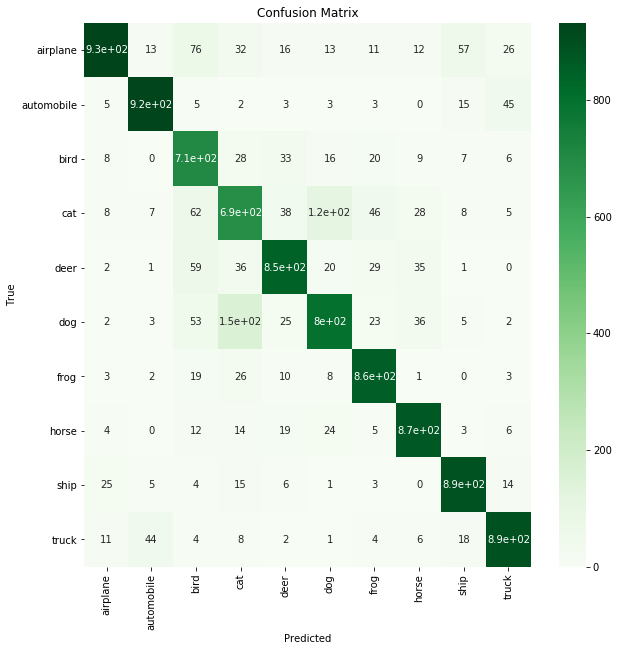

In [12]:
ytrue = np.where(y_test == 1)[1]
yprob = model.predict(x_test) 
ypredict = yprob.argmax(axis=-1)

confusion_mat = confusion_matrix(ypredict, ytrue)
df_confusion_mat = pd.DataFrame(confusion_mat,index=["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"],columns=["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"])

plt.figure(figsize = (10,10))
sns.heatmap(df_confusion_mat, xticklabels=True, yticklabels=True,cmap="Greens",annot=True)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
  

In [13]:
from sklearn.metrics import classification_report
target_names = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]
print(classification_report(ytrue, ypredict, target_names=target_names))
              

             precision    recall  f1-score   support

   airplane       0.78      0.93      0.85      1000
 automobile       0.92      0.93      0.92      1000
       bird       0.85      0.71      0.77      1000
        cat       0.68      0.69      0.68      1000
       deer       0.82      0.85      0.84      1000
        dog       0.73      0.80      0.76      1000
       frog       0.92      0.86      0.89      1000
      horse       0.91      0.87      0.89      1000
       ship       0.92      0.89      0.90      1000
      truck       0.90      0.89      0.90      1000

avg / total       0.84      0.84      0.84     10000



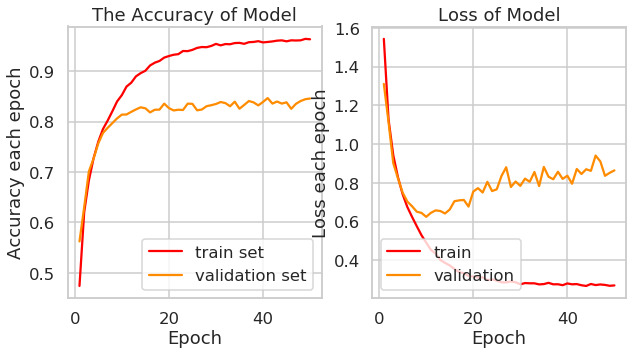

In [14]:
%matplotlib inline

# Plot the accuracy of Model
def model_accuracy_cost(track):
  
    sns.set_context("talk")
    sns.set_style("whitegrid")
    
    fig, axs = plt.subplots(1, 2,figsize=(10, 5))
    # The plot of accuracy
    axs[0].plot(range(1,51),track.history['acc'],color='red')
    axs[0].plot(range(1,51),track.history['val_acc'],color='darkorange')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Accuracy each epoch')
    axs[0].set_title('The Accuracy of Model')
    axs[0].legend(['train set', 'validation set'], loc=4)
    
    # The plot of loss 
    axs[1].plot(range(1,51),track.history['loss'],color='red')
    axs[1].plot(range(1,51),track.history['val_loss'],color='darkorange')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Loss each epoch')
    axs[1].set_xlabel('Epoch')
    axs[1].set_title('Loss of Model')
    axs[1].legend(['train', 'validation'], loc=3)
    
    plt.show()
    
# Plot show
model_accuracy_cost(fit)
